===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============
===========Done!===============


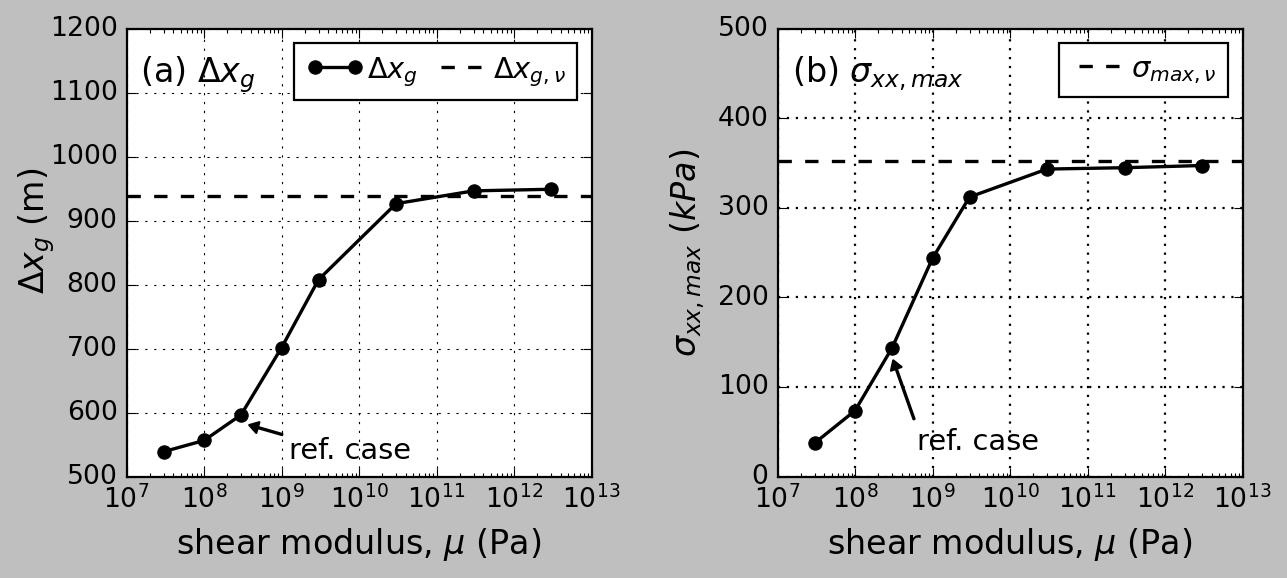

In [8]:
#======================= import essential libraries ===========================
import os
import math
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks
from scipy.integrate import simps 

#======================= input parameters  ===========================
Hght = 500               # Height(m)
Lngth = 2e4              # Lngth(m)               
tol = 1e-3               # Tolerance(m)
T = 0.5*3.154e7/(12.0*30.0)  # solar tide period
sea_level = Hght*0.917   # sea level(m)
r_lake = 0.5e3           # lake redius
KIc = 1e5                # Ice fracture toughness
rho_w = 1e3              # water density (kg/m^3)
rho_i = 917              # ice density (kg/m^3)
g = 9.8 # m/s^2          # gravity (m/s^2)
pi=math.pi               # pi
basin_elev = 80.0        # basin_elevation (m)
depth_basin = 90.0 - basin_elev  # basin depth (m)
# plot settings
fs = 15
marker = 6               # MarkerType
ny=1e4                   # y grid resolution

#======================= read data ===========================
# cases to be included
vfile =['./results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e8_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu1_00e8_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e9_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu1_00e9_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e10_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e11_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e12_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/convergence_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_mu0_30e13_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12',\
        './results/stokes_tidal_response_U09ma_L20000_Slope2e_2_A3e_24_n3_0_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12']
        
# correct the name of results
for file in vfile:
    path =  file + "/line_plot_data"
    # print "name :", os.listdir(path)
    listName = os.listdir(path)
    for files in listName:
        if files[-4:]=='.txt':
            continue
        else:
            txtName = files + '.txt'
            os.rename(os.path.join(path,files), os.path.join(path,txtName))
    print ("===========Done!===============")

X = [] # list of xcoord
x_left = []
x_right = []
s_mean = []
h_mean = []
max_tension = []
max_tension_net = []

t =  np.loadtxt( vfile[0] + "/line_plot_data/t.txt", dtype='f', delimiter=' ')
max_row = np.shape(t)[0]
for file in vfile:
    X.append(np.loadtxt( file + "/line_plot_data/X.txt", dtype='f', delimiter=' ',max_rows=max_row))
    x_left.append(np.loadtxt( file + "/line_plot_data/x_left.txt", dtype='f', delimiter=' ',max_rows=max_row))
    x_right.append(np.loadtxt( file + "/line_plot_data/x_right.txt", dtype='f', delimiter=' ',max_rows=max_row))
    s_mean.append(np.loadtxt( file + "/line_plot_data/s_mean.txt", dtype='f', delimiter=' ',max_rows=max_row))
    h_mean.append(np.loadtxt( file + "/line_plot_data/h_mean.txt", dtype='f', delimiter=' ',max_rows=max_row))
    max_tension_net.append(np.loadtxt( file + "/max_tension_net.txt", dtype='f', delimiter=' ',max_rows=max_row))
    max_tension.append(np.loadtxt( file + "/max_tension.txt", dtype='f', delimiter=' ',max_rows=max_row))

vmu = [0.3e8,1e8,0.3e9,1e9,0.3e10,0.3e11,0.3e12,0.3e13]
# =========================== figure =========================== 
fig,ax = plt.subplots(figsize=(9,3.5),nrows=1,ncols=2, constrained_layout=False)
plt.rcParams["figure.dpi"] = 300
plt.style.use('classic')
%config InlineBackend.figure_format = 'retina' # make high res plots for retina 5k displays

# range of the time
na = np.argmin(np.abs(t/T-19.0))               
nb = np.argmin(np.abs(t/T-20.0)) 

# labels = ['(a) DX=6.25','(a) DX=25','(b) DX=50','(c) DX=100']
labels = ['(a) mu=0.3e8','(b) mu=1e8','(b) mu=0.3e9','(c) mu=1e9','(d) mu=0.3e10','(e) viscous']
vcolor = ['k','y','b','r','g']
# =================== (a) ======================
ax = plt.subplot(121)
count =0
xr_range = []
xl_range = []
for i,file in enumerate(vfile):
    xr_range.append(x_right[i][na:nb].max())
    xl_range.append(x_left[i][na:nb].min())
    count += 1
xr_range = np.array(xr_range)
xl_range = np.array(xl_range)

delta_xg = xr_range-xl_range
ax.plot(vmu,delta_xg[:-1],'-',color='k',linewidth = 1.5,marker='o',markersize=6,label=r'$\Delta x_g$')    

# viscous solution
ax.axhline(y=delta_xg[-1],xmin=0,xmax=3e12,linewidth=1.5,linestyle='--',color='k',label=r'$\Delta x_{g,\nu}$')

ax.annotate(r'ref. case',xy=(vmu[2]*1.2,delta_xg[2]-15),xytext=(0.35,0.04), xycoords='data', textcoords='axes fraction',\
            fontsize=fs-2, math_fontfamily='dejavusans',\
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=4),)

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylim([500,1200])
ax.set_ylabel(r'$\Delta x_g$ (m)', math_fontfamily='dejavusans',fontsize = fs)
ax.yaxis.set_label_coords(-.15, .55)

ax.set_xlabel(r'shear modulus, $\mu$ (Pa)',fontsize = fs, math_fontfamily='dejavusans')
font = font_manager.FontProperties(math_fontfamily='dejavusans',
                                   style='normal', size=fs-2)
lgd = ax.legend(loc="upper right",ncol=2,prop=font,\
                fontsize=fs-2,labelspacing = 0.1,markerscale=1,handletextpad=0.1,columnspacing=0.5)

ax.grid(True,linewidth=0.5)
ax.annotate('(a) $\Delta x_g$',xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs, math_fontfamily='dejavusans')

# =================== (b) ======================
ax = plt.subplot(122)
count =0
sigma = []
for i,file in enumerate(vfile):
    sigma_max = np.max(max_tension_net[i][na:nb])
    sigma.append(sigma_max)
    count += 1
sigma = np.array(sigma)
ax.plot(vmu,sigma[:-1]/1e3,'-',color=vcolor[0],linewidth = 1.5,marker='o')    
# viscous solution
ax.axhline(y=sigma[-1]/1e3,xmin=0,xmax=3e12,linewidth=1.5,linestyle='--',color='k',label=r'$\sigma_{max,\nu}$')
ax.annotate(r'ref. case',xy=(vmu[2],sigma[2]/1e3-10),xytext=(0.3,0.06), xycoords='data', textcoords='axes fraction',\
            fontsize=fs-2, math_fontfamily='dejavusans',\
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=4),)

# y-axis
ax.set_ylim([0,500])
ax.set_ylabel(r'$\sigma_{xx,max}~(kPa)$',math_fontfamily='dejavusans',fontsize = fs)

# x-axis
ax.set_xscale('log')
ax.set_xlabel(r'shear modulus, $\mu$ (Pa)',fontsize = fs, math_fontfamily='dejavusans')

ax.grid(True,linewidth=1) # grid
ax.annotate('(b) $\sigma_{xx,max}$',xy=(0.03,0.88),xycoords='axes fraction',fontsize=fs, math_fontfamily='dejavusans')

font = font_manager.FontProperties(math_fontfamily='dejavusans',
                                   style='normal', size=fs-2)
lgd = ax.legend(loc="upper right",ncol=2,prop=font,\
                fontsize=fs-2,labelspacing = 0.1,markerscale=1,handletextpad=0.1,columnspacing=0.5)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.40, hspace=0.2)

plt.savefig('./figures/figure_6.tiff',bbox_inches='tight',dpi=600)